In [22]:
%matplotlib inline
%config IPCompleter.greedy=True

In [2]:
from opendrift.readers import reader_netCDF_CF_generic
from opendrift.models.oceandrift import OceanDrift
from parcels import FieldSet, ParticleSet, Variable, JITParticle, ScipyParticle, AdvectionRK4, plotTrajectoriesFile, Field
from netCDF4 import Dataset
from matplotlib import pyplot as plt
from datetime import timedelta
import numpy as np

#np.random.seed(13435)

In [58]:
def simulate_parcels(source_url, output_filename, lat, lon, wind_drift_percentage, velocity_average, hours=23):
    filenames = {'U' : source_url, 'V': source_url}
    dimensions = {'lat': 'lat','lon': 'lon','time': 'time'}

    if velocity_average: 
        variables = {'U': 'ubar', 'V': 'vbar'}
    else:
        variables = {'U': 'u', 'V': 'v'}

    fieldset = FieldSet.from_netcdf(filenames, variables, dimensions, interp_method = 'cgrid_velocity')
    
    if wind_drift_percentage:
        Uwind = Field.from_netcdf(source_url, ('U', 'Uwind'), dimensions, field_chunksize='auto', interp_method = 'cgrid_velocity')
        Vwind = Field.from_netcdf(source_url, ('V', 'Vwind'), dimensions, field_chunksize='auto', interp_method = 'cgrid_velocity')
        Uwind.set_scaling_factor(wind_drift_percentage)
        Vwind.set_scaling_factor(wind_drift_percentage)
        fieldset = FieldSet(U = fieldset.U+ Uwind,V = fieldset.V+ Vwind)

    pset = ParticleSet.from_list(fieldset = fieldset, pclass = JITParticle, lon=lon, lat=lat)
    output_file = pset.ParticleFile(name = output_filename, outputdt = timedelta(minutes=15))

    pset.execute(AdvectionRK4, runtime = timedelta(hours = hours), dt = timedelta(minutes=5), output_file = output_file)

    output_file.export()

In [4]:
def simulate_opendrift(source_url, lat, lon, wind_drift_percentage, velocity_average, hours=23):
    reader_norkyst = reader_netCDF_CF_generic.Reader(source_url)
    o = OceanDrift(loglevel=20)
    
    if velocity_average:
        reader_norkyst.variable_mapping['x_sea_water_velocity'] = 'ubar'
        reader_norkyst.variable_mapping['y_sea_water_velocity'] = 'vbar'
    
    o.add_reader(reader_norkyst, variables=['x_sea_water_velocity', 'y_sea_water_velocity', 'x_wind', 'y_wind'])
    
    o.seed_elements(lon= lon, lat=lat, radius=1, number=1, time=reader_norkyst.start_time, wind_drift_factor = wind_drift_percentage)
    
    o.set_config('drift:scheme', 'runge-kutta4')
    
    o.run(duration = timedelta(hours=hours), time_step = 300, time_step_output = 900)
    
    return o

In [56]:
def plot_compare(parcels_file, opendrift_obj = None):
    
    pfile = Dataset(parcels_file)
    #time = pfile.variables['time']
    plon = np.ma.filled(pfile.variables['lon'], np.nan)
    plat = np.ma.filled(pfile.variables['lat'], np.nan)
    fig, ax = plt.subplots(1, 1)
    ax.plot(np.transpose(plon), np.transpose(plat), '-')
    
    if (opendrift_obj != None):
        olon, olat = opendrift_obj.get_lonlats()
        ax.plot(olon.T, olat.T)


In [52]:
source_url =  '/home/johanna/gpu-ocean/gpu_ocean/demos/MPI_SIR/netcdf_cache/NorKyst-800m_ZDEPTHS_his.an.2019071600.nc'
lat = 60
lon = 4.9

In [59]:
simulate_parcels(source_url, 'ex1_nwnv.nc', lat,lon,0.0,False,23) #no wind. surface velocity
simulate_parcels(source_url, 'ex2_wnv.nc', lat,lon,0.02,False,23) #wind, surface velocity
simulate_parcels(source_url, 'ex3_nwv.nc', lat,lon,0.0,True,23) #no wind, average velocity
simulate_parcels(source_url, 'ex4_wv.nc', lat,lon,0.02,True,23) #wind, average velocity

INFO: Compiled JITParticleAdvectionRK4 ==> /tmp/parcels-1001/d36b598a700f98002fbb42b25dc504b1_0.so
INFO:parcels.tools.loggers:Compiled JITParticleAdvectionRK4 ==> /tmp/parcels-1001/d36b598a700f98002fbb42b25dc504b1_0.so
INFO: Temporary output files are stored in out-XIGXCPJE.
INFO:parcels.tools.loggers:Temporary output files are stored in out-XIGXCPJE.
INFO: You can use "parcels_convert_npydir_to_netcdf out-XIGXCPJE" to convert these to a NetCDF file during the run.
INFO:parcels.tools.loggers:You can use "parcels_convert_npydir_to_netcdf out-XIGXCPJE" to convert these to a NetCDF file during the run.
100% (82800.0 of 82800.0) |##############| Elapsed Time: 0:06:27 Time:  0:06:27
INFO: Compiled JITParticleAdvectionRK4 ==> /tmp/parcels-1001/dad033849cd5281c435ee6dfdb8db123_0.so
INFO:parcels.tools.loggers:Compiled JITParticleAdvectionRK4 ==> /tmp/parcels-1001/dad033849cd5281c435ee6dfdb8db123_0.so
INFO: Temporary output files are stored in out-KNSVSDHM.
INFO:parcels.tools.loggers:Temporary 

  warnings.warn('The .xlabels_top attribute is deprecated. Please '

  warnings.warn('The .ylabels_right attribute is deprecated. Please '



ValueError: Invalid transform: Spherical scatter is not supported - consider using PlateCarree/RotatedPole.

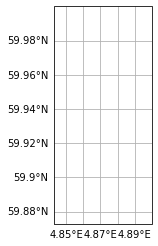

In [50]:
#plotTrajectoriesFile('ex1_nwnv.nc', mode = 'movie2d_notebook') 

In [13]:
o1 = simulate_opendrift(source_url, lat, lon, 0.0, False,23) #no wind, surface velocity
o2 = simulate_opendrift(source_url, lat, lon, 0.02, False, 23) #wind, surface velocity
o3 = simulate_opendrift(source_url, lat, lon, 0.0, True, 23) #no wind, average velocity
o4 = simulate_opendrift(source_url, lat, lon, 0.02, True, 23) #wind, average velocity

09:06:46 INFO: Opening dataset: /home/johanna/gpu-ocean/gpu_ocean/demos/MPI_SIR/netcdf_cache/NorKyst-800m_ZDEPTHS_his.an.2019071600.nc
09:06:46 INFO: Opening file with Dataset
09:06:47 INFO: OpenDriftSimulation initialised (version 1.2.3)
09:06:47 INFO: Config validation OK
09:06:47 INFO: Adding a dynamical landmask with max. priority based on assumed maximum speed of 1 m/s. Adding a customised landmask may be faster...
09:06:50 INFO: Using existing reader for land_binary_mask
09:06:50 INFO: All points are in ocean
09:06:50 INFO: 2019-07-16 00:00:00 - step 1 of 276 - 1 active elements (0 deactivated)
  condition = (xf < v1) | (xf > v2)

  condition = (xf < v1) | (xf > v2)

09:06:50 INFO: 2019-07-16 00:05:00 - step 2 of 276 - 1 active elements (0 deactivated)
09:06:50 INFO: 2019-07-16 00:10:00 - step 3 of 276 - 1 active elements (0 deactivated)
09:06:50 INFO: 2019-07-16 00:15:00 - step 4 of 276 - 1 active elements (0 deactivated)
09:06:50 INFO: 2019-07-16 00:20:00 - step 5 of 276 - 1 ac

09:06:52 INFO: 2019-07-16 06:55:00 - step 84 of 276 - 1 active elements (0 deactivated)
09:06:52 INFO: 2019-07-16 07:00:00 - step 85 of 276 - 1 active elements (0 deactivated)
09:06:52 INFO: 2019-07-16 07:05:00 - step 86 of 276 - 1 active elements (0 deactivated)
09:06:52 INFO: 2019-07-16 07:10:00 - step 87 of 276 - 1 active elements (0 deactivated)
09:06:52 INFO: 2019-07-16 07:15:00 - step 88 of 276 - 1 active elements (0 deactivated)
09:06:52 INFO: 2019-07-16 07:20:00 - step 89 of 276 - 1 active elements (0 deactivated)
09:06:52 INFO: 2019-07-16 07:25:00 - step 90 of 276 - 1 active elements (0 deactivated)
09:06:52 INFO: 2019-07-16 07:30:00 - step 91 of 276 - 1 active elements (0 deactivated)
09:06:52 INFO: 2019-07-16 07:35:00 - step 92 of 276 - 1 active elements (0 deactivated)
09:06:52 INFO: 2019-07-16 07:40:00 - step 93 of 276 - 1 active elements (0 deactivated)
09:06:52 INFO: 2019-07-16 07:45:00 - step 94 of 276 - 1 active elements (0 deactivated)
09:06:52 INFO: 2019-07-16 07:50:

09:06:54 INFO: 2019-07-16 14:40:00 - step 177 of 276 - 1 active elements (0 deactivated)
09:06:54 INFO: 2019-07-16 14:45:00 - step 178 of 276 - 1 active elements (0 deactivated)
09:06:54 INFO: 2019-07-16 14:50:00 - step 179 of 276 - 1 active elements (0 deactivated)
09:06:54 INFO: 2019-07-16 14:55:00 - step 180 of 276 - 1 active elements (0 deactivated)
09:06:54 INFO: 2019-07-16 15:00:00 - step 181 of 276 - 1 active elements (0 deactivated)
09:06:54 INFO: 2019-07-16 15:05:00 - step 182 of 276 - 1 active elements (0 deactivated)
09:06:54 INFO: 2019-07-16 15:10:00 - step 183 of 276 - 1 active elements (0 deactivated)
09:06:54 INFO: 2019-07-16 15:15:00 - step 184 of 276 - 1 active elements (0 deactivated)
09:06:54 INFO: 2019-07-16 15:20:00 - step 185 of 276 - 1 active elements (0 deactivated)
09:06:54 INFO: 2019-07-16 15:25:00 - step 186 of 276 - 1 active elements (0 deactivated)
09:06:54 INFO: 2019-07-16 15:30:00 - step 187 of 276 - 1 active elements (0 deactivated)
09:06:54 INFO: 2019-0

09:06:57 INFO: 2019-07-16 22:25:00 - step 270 of 276 - 1 active elements (0 deactivated)
09:06:57 INFO: 2019-07-16 22:30:00 - step 271 of 276 - 1 active elements (0 deactivated)
09:06:57 INFO: 2019-07-16 22:35:00 - step 272 of 276 - 1 active elements (0 deactivated)
09:06:57 INFO: 2019-07-16 22:40:00 - step 273 of 276 - 1 active elements (0 deactivated)
09:06:57 INFO: 2019-07-16 22:45:00 - step 274 of 276 - 1 active elements (0 deactivated)
09:06:57 INFO: 2019-07-16 22:50:00 - step 275 of 276 - 1 active elements (0 deactivated)
09:06:57 INFO: 2019-07-16 22:55:00 - step 276 of 276 - 1 active elements (0 deactivated)
09:06:57 INFO: Opening dataset: /home/johanna/gpu-ocean/gpu_ocean/demos/MPI_SIR/netcdf_cache/NorKyst-800m_ZDEPTHS_his.an.2019071600.nc
09:06:57 INFO: Opening file with Dataset
09:06:57 INFO: OpenDriftSimulation initialised (version 1.2.3)
09:06:57 INFO: Config validation OK
09:06:57 INFO: Adding a dynamical landmask with max. priority based on assumed maximum speed of 1 m/s.

09:07:01 INFO: 2019-07-16 06:20:00 - step 77 of 276 - 1 active elements (0 deactivated)
09:07:01 INFO: 2019-07-16 06:25:00 - step 78 of 276 - 1 active elements (0 deactivated)
09:07:01 INFO: 2019-07-16 06:30:00 - step 79 of 276 - 1 active elements (0 deactivated)
09:07:01 INFO: 2019-07-16 06:35:00 - step 80 of 276 - 1 active elements (0 deactivated)
09:07:01 INFO: 2019-07-16 06:40:00 - step 81 of 276 - 1 active elements (0 deactivated)
09:07:01 INFO: 2019-07-16 06:45:00 - step 82 of 276 - 1 active elements (0 deactivated)
09:07:01 INFO: 2019-07-16 06:50:00 - step 83 of 276 - 1 active elements (0 deactivated)
09:07:01 INFO: 2019-07-16 06:55:00 - step 84 of 276 - 1 active elements (0 deactivated)
09:07:01 INFO: 2019-07-16 07:00:00 - step 85 of 276 - 1 active elements (0 deactivated)
09:07:01 INFO: 2019-07-16 07:05:00 - step 86 of 276 - 1 active elements (0 deactivated)
09:07:01 INFO: 2019-07-16 07:10:00 - step 87 of 276 - 1 active elements (0 deactivated)
09:07:01 INFO: 2019-07-16 07:15:

09:07:03 INFO: 2019-07-16 14:05:00 - step 170 of 276 - 1 active elements (0 deactivated)
09:07:03 INFO: 2019-07-16 14:10:00 - step 171 of 276 - 1 active elements (0 deactivated)
09:07:03 INFO: 2019-07-16 14:15:00 - step 172 of 276 - 1 active elements (0 deactivated)
09:07:03 INFO: 2019-07-16 14:20:00 - step 173 of 276 - 1 active elements (0 deactivated)
09:07:03 INFO: 2019-07-16 14:25:00 - step 174 of 276 - 1 active elements (0 deactivated)
09:07:03 INFO: 2019-07-16 14:30:00 - step 175 of 276 - 1 active elements (0 deactivated)
09:07:03 INFO: 2019-07-16 14:35:00 - step 176 of 276 - 1 active elements (0 deactivated)
09:07:03 INFO: 2019-07-16 14:40:00 - step 177 of 276 - 1 active elements (0 deactivated)
09:07:03 INFO: 2019-07-16 14:45:00 - step 178 of 276 - 1 active elements (0 deactivated)
09:07:03 INFO: 2019-07-16 14:50:00 - step 179 of 276 - 1 active elements (0 deactivated)
09:07:03 INFO: 2019-07-16 14:55:00 - step 180 of 276 - 1 active elements (0 deactivated)
09:07:03 INFO: 2019-0

09:07:05 INFO: 2019-07-16 21:50:00 - step 263 of 276 - 1 active elements (0 deactivated)
09:07:05 INFO: 2019-07-16 21:55:00 - step 264 of 276 - 1 active elements (0 deactivated)
09:07:05 INFO: 2019-07-16 22:00:00 - step 265 of 276 - 1 active elements (0 deactivated)
09:07:05 INFO: 2019-07-16 22:05:00 - step 266 of 276 - 1 active elements (0 deactivated)
09:07:05 INFO: 2019-07-16 22:10:00 - step 267 of 276 - 1 active elements (0 deactivated)
09:07:05 INFO: 2019-07-16 22:15:00 - step 268 of 276 - 1 active elements (0 deactivated)
09:07:05 INFO: 2019-07-16 22:20:00 - step 269 of 276 - 1 active elements (0 deactivated)
09:07:05 INFO: 2019-07-16 22:25:00 - step 270 of 276 - 1 active elements (0 deactivated)
09:07:05 INFO: 2019-07-16 22:30:00 - step 271 of 276 - 1 active elements (0 deactivated)
09:07:05 INFO: 2019-07-16 22:35:00 - step 272 of 276 - 1 active elements (0 deactivated)
09:07:05 INFO: 2019-07-16 22:40:00 - step 273 of 276 - 1 active elements (0 deactivated)
09:07:05 INFO: 2019-0

09:07:09 INFO: 2019-07-16 05:45:00 - step 70 of 276 - 1 active elements (0 deactivated)
09:07:09 INFO: 2019-07-16 05:50:00 - step 71 of 276 - 1 active elements (0 deactivated)
09:07:09 INFO: 2019-07-16 05:55:00 - step 72 of 276 - 1 active elements (0 deactivated)
09:07:09 INFO: 2019-07-16 06:00:00 - step 73 of 276 - 1 active elements (0 deactivated)
09:07:09 INFO: 2019-07-16 06:05:00 - step 74 of 276 - 1 active elements (0 deactivated)
09:07:09 INFO: 2019-07-16 06:10:00 - step 75 of 276 - 1 active elements (0 deactivated)
09:07:09 INFO: 2019-07-16 06:15:00 - step 76 of 276 - 1 active elements (0 deactivated)
09:07:09 INFO: 2019-07-16 06:20:00 - step 77 of 276 - 1 active elements (0 deactivated)
09:07:09 INFO: 2019-07-16 06:25:00 - step 78 of 276 - 1 active elements (0 deactivated)
09:07:09 INFO: 2019-07-16 06:30:00 - step 79 of 276 - 1 active elements (0 deactivated)
09:07:09 INFO: 2019-07-16 06:35:00 - step 80 of 276 - 1 active elements (0 deactivated)
09:07:09 INFO: 2019-07-16 06:40:

09:07:11 INFO: 2019-07-16 13:30:00 - step 163 of 276 - 1 active elements (0 deactivated)
09:07:11 INFO: 2019-07-16 13:35:00 - step 164 of 276 - 1 active elements (0 deactivated)
09:07:11 INFO: 2019-07-16 13:40:00 - step 165 of 276 - 1 active elements (0 deactivated)
09:07:11 INFO: 2019-07-16 13:45:00 - step 166 of 276 - 1 active elements (0 deactivated)
09:07:11 INFO: 2019-07-16 13:50:00 - step 167 of 276 - 1 active elements (0 deactivated)
09:07:11 INFO: 2019-07-16 13:55:00 - step 168 of 276 - 1 active elements (0 deactivated)
09:07:11 INFO: 2019-07-16 14:00:00 - step 169 of 276 - 1 active elements (0 deactivated)
09:07:11 INFO: 2019-07-16 14:05:00 - step 170 of 276 - 1 active elements (0 deactivated)
09:07:11 INFO: 2019-07-16 14:10:00 - step 171 of 276 - 1 active elements (0 deactivated)
09:07:11 INFO: 2019-07-16 14:15:00 - step 172 of 276 - 1 active elements (0 deactivated)
09:07:11 INFO: 2019-07-16 14:20:00 - step 173 of 276 - 1 active elements (0 deactivated)
09:07:11 INFO: 2019-0

09:07:12 INFO: 2019-07-16 21:15:00 - step 256 of 276 - 1 active elements (0 deactivated)
09:07:12 INFO: 2019-07-16 21:20:00 - step 257 of 276 - 1 active elements (0 deactivated)
09:07:12 INFO: 2019-07-16 21:25:00 - step 258 of 276 - 1 active elements (0 deactivated)
09:07:12 INFO: 2019-07-16 21:30:00 - step 259 of 276 - 1 active elements (0 deactivated)
09:07:12 INFO: 2019-07-16 21:35:00 - step 260 of 276 - 1 active elements (0 deactivated)
09:07:12 INFO: 2019-07-16 21:40:00 - step 261 of 276 - 1 active elements (0 deactivated)
09:07:12 INFO: 2019-07-16 21:45:00 - step 262 of 276 - 1 active elements (0 deactivated)
09:07:12 INFO: 2019-07-16 21:50:00 - step 263 of 276 - 1 active elements (0 deactivated)
09:07:12 INFO: 2019-07-16 21:55:00 - step 264 of 276 - 1 active elements (0 deactivated)
09:07:12 INFO: 2019-07-16 22:00:00 - step 265 of 276 - 1 active elements (0 deactivated)
09:07:12 INFO: 2019-07-16 22:05:00 - step 266 of 276 - 1 active elements (0 deactivated)
09:07:12 INFO: 2019-0

09:07:16 INFO: 2019-07-16 05:10:00 - step 63 of 276 - 1 active elements (0 deactivated)
09:07:16 INFO: 2019-07-16 05:15:00 - step 64 of 276 - 1 active elements (0 deactivated)
09:07:16 INFO: 2019-07-16 05:20:00 - step 65 of 276 - 1 active elements (0 deactivated)
09:07:16 INFO: 2019-07-16 05:25:00 - step 66 of 276 - 1 active elements (0 deactivated)
09:07:16 INFO: 2019-07-16 05:30:00 - step 67 of 276 - 1 active elements (0 deactivated)
09:07:16 INFO: 2019-07-16 05:35:00 - step 68 of 276 - 1 active elements (0 deactivated)
09:07:16 INFO: 2019-07-16 05:40:00 - step 69 of 276 - 1 active elements (0 deactivated)
09:07:16 INFO: 2019-07-16 05:45:00 - step 70 of 276 - 1 active elements (0 deactivated)
09:07:16 INFO: 2019-07-16 05:50:00 - step 71 of 276 - 1 active elements (0 deactivated)
09:07:16 INFO: 2019-07-16 05:55:00 - step 72 of 276 - 1 active elements (0 deactivated)
09:07:16 INFO: 2019-07-16 06:00:00 - step 73 of 276 - 1 active elements (0 deactivated)
09:07:16 INFO: 2019-07-16 06:05:

09:07:17 INFO: 2019-07-16 12:55:00 - step 156 of 276 - 1 active elements (0 deactivated)
09:07:17 INFO: 2019-07-16 13:00:00 - step 157 of 276 - 1 active elements (0 deactivated)
09:07:17 INFO: 2019-07-16 13:05:00 - step 158 of 276 - 1 active elements (0 deactivated)
09:07:18 INFO: 2019-07-16 13:10:00 - step 159 of 276 - 1 active elements (0 deactivated)
09:07:18 INFO: 2019-07-16 13:15:00 - step 160 of 276 - 1 active elements (0 deactivated)
09:07:18 INFO: 2019-07-16 13:20:00 - step 161 of 276 - 1 active elements (0 deactivated)
09:07:18 INFO: 2019-07-16 13:25:00 - step 162 of 276 - 1 active elements (0 deactivated)
09:07:18 INFO: 2019-07-16 13:30:00 - step 163 of 276 - 1 active elements (0 deactivated)
09:07:18 INFO: 2019-07-16 13:35:00 - step 164 of 276 - 1 active elements (0 deactivated)
09:07:18 INFO: 2019-07-16 13:40:00 - step 165 of 276 - 1 active elements (0 deactivated)
09:07:18 INFO: 2019-07-16 13:45:00 - step 166 of 276 - 1 active elements (0 deactivated)
09:07:18 INFO: 2019-0

09:07:19 INFO: 2019-07-16 20:40:00 - step 249 of 276 - 1 active elements (0 deactivated)
09:07:19 INFO: 2019-07-16 20:45:00 - step 250 of 276 - 1 active elements (0 deactivated)
09:07:19 INFO: 2019-07-16 20:50:00 - step 251 of 276 - 1 active elements (0 deactivated)
09:07:19 INFO: 2019-07-16 20:55:00 - step 252 of 276 - 1 active elements (0 deactivated)
09:07:19 INFO: 2019-07-16 21:00:00 - step 253 of 276 - 1 active elements (0 deactivated)
09:07:19 INFO: 2019-07-16 21:05:00 - step 254 of 276 - 1 active elements (0 deactivated)
09:07:19 INFO: 2019-07-16 21:10:00 - step 255 of 276 - 1 active elements (0 deactivated)
09:07:19 INFO: 2019-07-16 21:15:00 - step 256 of 276 - 1 active elements (0 deactivated)
09:07:19 INFO: 2019-07-16 21:20:00 - step 257 of 276 - 1 active elements (0 deactivated)
09:07:19 INFO: 2019-07-16 21:25:00 - step 258 of 276 - 1 active elements (0 deactivated)
09:07:19 INFO: 2019-07-16 21:30:00 - step 259 of 276 - 1 active elements (0 deactivated)
09:07:19 INFO: 2019-0

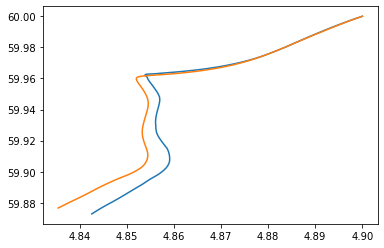

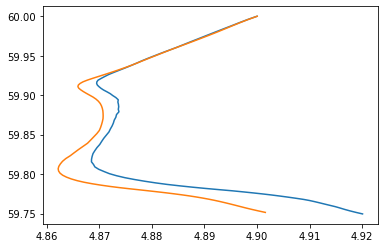

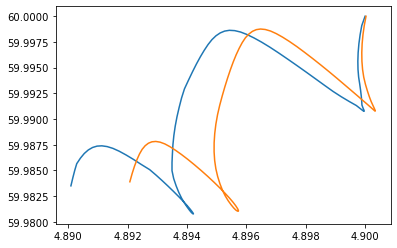

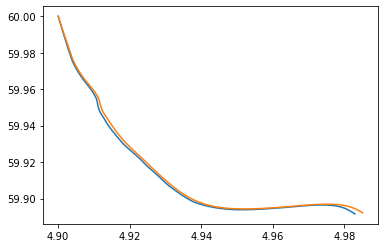

In [60]:
plot_compare('ex1_nwnv.nc', o1)
plot_compare('ex2_wnv.nc', o2)
plot_compare('ex3_nwv.nc', o3)
plot_compare('ex4_wv.nc', o4)

10:17:46 WARNING: plotting fast. this will make your plots less accurate.


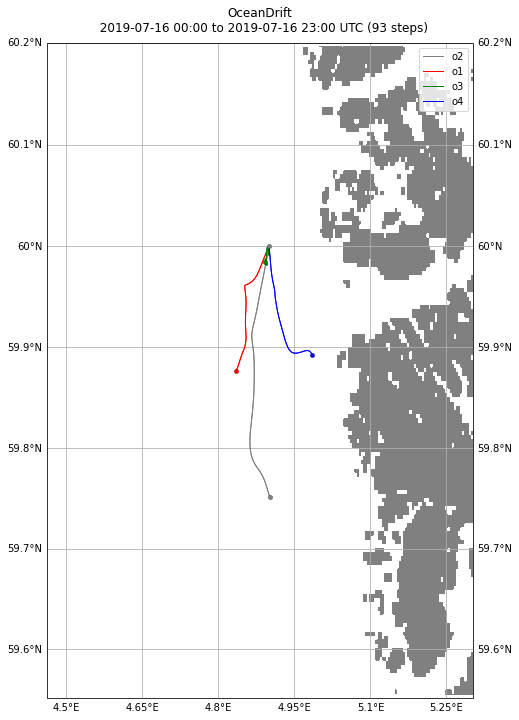

(<cartopy.mpl.geoaxes.GeoAxesSubplot at 0x7f32c5385050>,
 <module 'matplotlib.pyplot' from '/home/johanna/miniconda3/envs/gpuocean_parcels_opendrift/lib/python3.7/site-packages/matplotlib/pyplot.py'>)

In [46]:
o2.plot(fast = True, compare = [o1,o3,o4], legend = ['o2','o1','o3','o4'])

In [7]:
#COORDINATE CHANGE ROM LON/LAT TO XY IN OPENDRIFT
def coordinate_change(o):
    t = o.get_time_array()[1]
    for i in range(len(t)):
        t[i] = t[i].total_seconds()
    t = np.array(t)

    lon, lat = o.get_lonlats()
    x,y = o.lonlat2xy(lon,lat)
    
    return t,x,y # Or save t,x,y?

In [37]:
url_list = ['/home/johanna/gpu-ocean/gpu_ocean/demos/MPI_SIR/netcdf_cache/NorKyst-800m_ZDEPTHS_his.an.2019071600.nc',
            '/home/johanna/gpu-ocean/gpu_ocean/demos/MPI_SIR/netcdf_cache/NorKyst-800m_ZDEPTHS_his.an.2019071700.nc',
            '/home/johanna/gpu-ocean/gpu_ocean/demos/MPI_SIR/netcdf_cache/NorKyst-800m_ZDEPTHS_his.an.2019071800.nc']

In [39]:
o6 = simulate_opendrift(url_list, 60.12,5.55, 0.0, True,23*3) #no wind, average velocity

09:34:39 INFO: Opening dataset: ['/home/johanna/gpu-ocean/gpu_ocean/demos/MPI_SIR/netcdf_cache/NorKyst-800m_ZDEPTHS_his.an.2019071600.nc', '/home/johanna/gpu-ocean/gpu_ocean/demos/MPI_SIR/netcdf_cache/NorKyst-800m_ZDEPTHS_his.an.2019071700.nc', '/home/johanna/gpu-ocean/gpu_ocean/demos/MPI_SIR/netcdf_cache/NorKyst-800m_ZDEPTHS_his.an.2019071800.nc']
09:34:39 INFO: Opening files with MFDataset
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  self.Dataset = xr.open_mfdataset(filename)

to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, please use the new
`combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  from_openmfds=Tru

09:38:44 INFO: 2019-07-16 06:05:00 - step 74 of 828 - 1 active elements (0 deactivated)
09:38:44 INFO: 2019-07-16 06:10:00 - step 75 of 828 - 1 active elements (0 deactivated)
09:38:44 INFO: 2019-07-16 06:15:00 - step 76 of 828 - 1 active elements (0 deactivated)
09:38:44 INFO: 2019-07-16 06:20:00 - step 77 of 828 - 1 active elements (0 deactivated)
09:38:44 INFO: 2019-07-16 06:25:00 - step 78 of 828 - 1 active elements (0 deactivated)
09:38:44 INFO: 2019-07-16 06:30:00 - step 79 of 828 - 1 active elements (0 deactivated)
09:38:44 INFO: 2019-07-16 06:35:00 - step 80 of 828 - 1 active elements (0 deactivated)
09:38:44 INFO: 2019-07-16 06:40:00 - step 81 of 828 - 1 active elements (0 deactivated)
09:38:44 INFO: 2019-07-16 06:45:00 - step 82 of 828 - 1 active elements (0 deactivated)
09:38:44 INFO: 2019-07-16 06:50:00 - step 83 of 828 - 1 active elements (0 deactivated)
09:38:44 INFO: 2019-07-16 06:55:00 - step 84 of 828 - 1 active elements (0 deactivated)
09:38:44 INFO: 2019-07-16 07:00:

09:42:29 INFO: 2019-07-16 13:50:00 - step 167 of 828 - 1 active elements (0 deactivated)
09:42:29 INFO: 2019-07-16 13:55:00 - step 168 of 828 - 1 active elements (0 deactivated)
09:42:29 INFO: 2019-07-16 14:00:00 - step 169 of 828 - 1 active elements (0 deactivated)
09:42:58 INFO: 2019-07-16 14:05:00 - step 170 of 828 - 1 active elements (0 deactivated)
09:42:58 INFO: 2019-07-16 14:10:00 - step 171 of 828 - 1 active elements (0 deactivated)
09:42:58 INFO: 2019-07-16 14:15:00 - step 172 of 828 - 1 active elements (0 deactivated)
09:42:58 INFO: 2019-07-16 14:20:00 - step 173 of 828 - 1 active elements (0 deactivated)
09:42:58 INFO: 2019-07-16 14:25:00 - step 174 of 828 - 1 active elements (0 deactivated)
09:42:58 INFO: 2019-07-16 14:30:00 - step 175 of 828 - 1 active elements (0 deactivated)
09:42:58 INFO: 2019-07-16 14:35:00 - step 176 of 828 - 1 active elements (0 deactivated)
09:42:58 INFO: 2019-07-16 14:40:00 - step 177 of 828 - 1 active elements (0 deactivated)
09:42:58 INFO: 2019-0

09:46:30 INFO: 2019-07-16 21:35:00 - step 260 of 828 - 1 active elements (0 deactivated)
09:46:30 INFO: 2019-07-16 21:40:00 - step 261 of 828 - 1 active elements (0 deactivated)
09:46:30 INFO: 2019-07-16 21:45:00 - step 262 of 828 - 1 active elements (0 deactivated)
09:46:30 INFO: 2019-07-16 21:50:00 - step 263 of 828 - 1 active elements (0 deactivated)
09:46:30 INFO: 2019-07-16 21:55:00 - step 264 of 828 - 1 active elements (0 deactivated)
09:46:30 INFO: 2019-07-16 22:00:00 - step 265 of 828 - 1 active elements (0 deactivated)
09:47:03 INFO: 2019-07-16 22:05:00 - step 266 of 828 - 1 active elements (0 deactivated)
09:47:03 INFO: 2019-07-16 22:10:00 - step 267 of 828 - 1 active elements (0 deactivated)
09:47:03 INFO: 2019-07-16 22:15:00 - step 268 of 828 - 1 active elements (0 deactivated)
09:47:03 INFO: 2019-07-16 22:20:00 - step 269 of 828 - 1 active elements (0 deactivated)
09:47:03 INFO: 2019-07-16 22:25:00 - step 270 of 828 - 1 active elements (0 deactivated)
09:47:03 INFO: 2019-0

09:50:37 INFO: 2019-07-17 05:20:00 - step 353 of 828 - 1 active elements (0 deactivated)
09:50:37 INFO: 2019-07-17 05:25:00 - step 354 of 828 - 1 active elements (0 deactivated)
09:50:37 INFO: 2019-07-17 05:30:00 - step 355 of 828 - 1 active elements (0 deactivated)
09:50:37 INFO: 2019-07-17 05:35:00 - step 356 of 828 - 1 active elements (0 deactivated)
09:50:37 INFO: 2019-07-17 05:40:00 - step 357 of 828 - 1 active elements (0 deactivated)
09:50:37 INFO: 2019-07-17 05:45:00 - step 358 of 828 - 1 active elements (0 deactivated)
09:50:37 INFO: 2019-07-17 05:50:00 - step 359 of 828 - 1 active elements (0 deactivated)
09:50:37 INFO: 2019-07-17 05:55:00 - step 360 of 828 - 1 active elements (0 deactivated)
09:50:37 INFO: 2019-07-17 06:00:00 - step 361 of 828 - 1 active elements (0 deactivated)
09:51:07 INFO: 2019-07-17 06:05:00 - step 362 of 828 - 1 active elements (0 deactivated)
09:51:07 INFO: 2019-07-17 06:10:00 - step 363 of 828 - 1 active elements (0 deactivated)
09:51:07 INFO: 2019-0

09:54:55 INFO: 2019-07-17 13:05:00 - step 446 of 828 - 1 active elements (0 deactivated)
09:54:55 INFO: 2019-07-17 13:10:00 - step 447 of 828 - 1 active elements (0 deactivated)
09:54:55 INFO: 2019-07-17 13:15:00 - step 448 of 828 - 1 active elements (0 deactivated)
09:54:55 INFO: 2019-07-17 13:20:00 - step 449 of 828 - 1 active elements (0 deactivated)
09:54:55 INFO: 2019-07-17 13:25:00 - step 450 of 828 - 1 active elements (0 deactivated)
09:54:55 INFO: 2019-07-17 13:30:00 - step 451 of 828 - 1 active elements (0 deactivated)
09:54:55 INFO: 2019-07-17 13:35:00 - step 452 of 828 - 1 active elements (0 deactivated)
09:54:55 INFO: 2019-07-17 13:40:00 - step 453 of 828 - 1 active elements (0 deactivated)
09:54:55 INFO: 2019-07-17 13:45:00 - step 454 of 828 - 1 active elements (0 deactivated)
09:54:55 INFO: 2019-07-17 13:50:00 - step 455 of 828 - 1 active elements (0 deactivated)
09:54:55 INFO: 2019-07-17 13:55:00 - step 456 of 828 - 1 active elements (0 deactivated)
09:54:55 INFO: 2019-0

09:58:35 INFO: 2019-07-17 20:50:00 - step 539 of 828 - 1 active elements (0 deactivated)
09:58:35 INFO: 2019-07-17 20:55:00 - step 540 of 828 - 1 active elements (0 deactivated)
09:58:35 INFO: 2019-07-17 21:00:00 - step 541 of 828 - 1 active elements (0 deactivated)
09:59:07 INFO: 2019-07-17 21:05:00 - step 542 of 828 - 1 active elements (0 deactivated)
09:59:07 INFO: 2019-07-17 21:10:00 - step 543 of 828 - 1 active elements (0 deactivated)
09:59:07 INFO: 2019-07-17 21:15:00 - step 544 of 828 - 1 active elements (0 deactivated)
09:59:07 INFO: 2019-07-17 21:20:00 - step 545 of 828 - 1 active elements (0 deactivated)
09:59:07 INFO: 2019-07-17 21:25:00 - step 546 of 828 - 1 active elements (0 deactivated)
09:59:07 INFO: 2019-07-17 21:30:00 - step 547 of 828 - 1 active elements (0 deactivated)
09:59:07 INFO: 2019-07-17 21:35:00 - step 548 of 828 - 1 active elements (0 deactivated)
09:59:07 INFO: 2019-07-17 21:40:00 - step 549 of 828 - 1 active elements (0 deactivated)
09:59:07 INFO: 2019-0

10:02:20 INFO: 2019-07-18 04:35:00 - step 632 of 828 - 1 active elements (0 deactivated)
10:02:20 INFO: 2019-07-18 04:40:00 - step 633 of 828 - 1 active elements (0 deactivated)
10:02:20 INFO: 2019-07-18 04:45:00 - step 634 of 828 - 1 active elements (0 deactivated)
10:02:20 INFO: 2019-07-18 04:50:00 - step 635 of 828 - 1 active elements (0 deactivated)
10:02:20 INFO: 2019-07-18 04:55:00 - step 636 of 828 - 1 active elements (0 deactivated)
10:02:20 INFO: 2019-07-18 05:00:00 - step 637 of 828 - 1 active elements (0 deactivated)
10:02:47 INFO: 2019-07-18 05:05:00 - step 638 of 828 - 1 active elements (0 deactivated)
10:02:47 INFO: 2019-07-18 05:10:00 - step 639 of 828 - 1 active elements (0 deactivated)
10:02:47 INFO: 2019-07-18 05:15:00 - step 640 of 828 - 1 active elements (0 deactivated)
10:02:47 INFO: 2019-07-18 05:20:00 - step 641 of 828 - 1 active elements (0 deactivated)
10:02:47 INFO: 2019-07-18 05:25:00 - step 642 of 828 - 1 active elements (0 deactivated)
10:02:47 INFO: 2019-0

10:05:36 INFO: 2019-07-18 12:20:00 - step 725 of 828 - 1 active elements (0 deactivated)
10:05:36 INFO: 2019-07-18 12:25:00 - step 726 of 828 - 1 active elements (0 deactivated)
10:05:36 INFO: 2019-07-18 12:30:00 - step 727 of 828 - 1 active elements (0 deactivated)
10:05:36 INFO: 2019-07-18 12:35:00 - step 728 of 828 - 1 active elements (0 deactivated)
10:05:36 INFO: 2019-07-18 12:40:00 - step 729 of 828 - 1 active elements (0 deactivated)
10:05:36 INFO: 2019-07-18 12:45:00 - step 730 of 828 - 1 active elements (0 deactivated)
10:05:36 INFO: 2019-07-18 12:50:00 - step 731 of 828 - 1 active elements (0 deactivated)
10:05:36 INFO: 2019-07-18 12:55:00 - step 732 of 828 - 1 active elements (0 deactivated)
10:05:36 INFO: 2019-07-18 13:00:00 - step 733 of 828 - 1 active elements (0 deactivated)
10:05:59 INFO: 2019-07-18 13:05:00 - step 734 of 828 - 1 active elements (0 deactivated)
10:06:00 INFO: 2019-07-18 13:10:00 - step 735 of 828 - 1 active elements (0 deactivated)
10:06:00 INFO: 2019-0

10:09:07 INFO: 2019-07-18 20:05:00 - step 818 of 828 - 1 active elements (0 deactivated)
10:09:07 INFO: 2019-07-18 20:10:00 - step 819 of 828 - 1 active elements (0 deactivated)
10:09:07 INFO: 2019-07-18 20:15:00 - step 820 of 828 - 1 active elements (0 deactivated)
10:09:07 INFO: 2019-07-18 20:20:00 - step 821 of 828 - 1 active elements (0 deactivated)
10:09:07 INFO: 2019-07-18 20:25:00 - step 822 of 828 - 1 active elements (0 deactivated)
10:09:07 INFO: 2019-07-18 20:30:00 - step 823 of 828 - 1 active elements (0 deactivated)
10:09:07 INFO: 2019-07-18 20:35:00 - step 824 of 828 - 1 active elements (0 deactivated)
10:09:07 INFO: 2019-07-18 20:40:00 - step 825 of 828 - 1 active elements (0 deactivated)
10:09:07 INFO: 2019-07-18 20:45:00 - step 826 of 828 - 1 active elements (0 deactivated)
10:09:07 INFO: 2019-07-18 20:50:00 - step 827 of 828 - 1 active elements (0 deactivated)
10:09:07 INFO: 2019-07-18 20:55:00 - step 828 of 828 - 1 active elements (0 deactivated)


10:09:07 WARNING: plotting fast. this will make your plots less accurate.


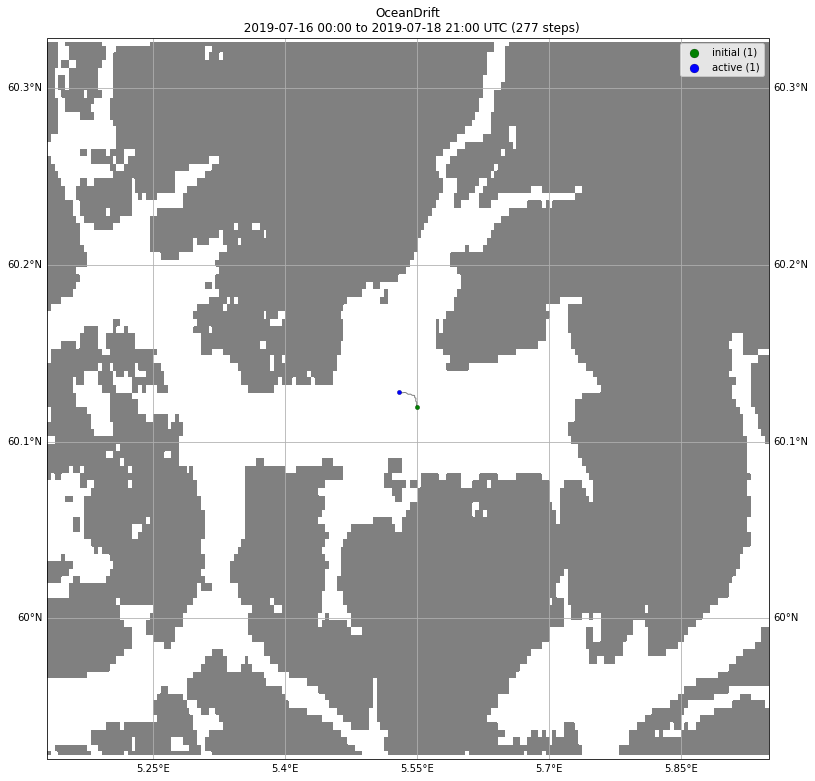

(<cartopy.mpl.geoaxes.GeoAxesSubplot at 0x7f32c56b0f10>,
 <module 'matplotlib.pyplot' from '/home/johanna/miniconda3/envs/gpuocean_parcels_opendrift/lib/python3.7/site-packages/matplotlib/pyplot.py'>)

In [40]:
o6.plot(fast = True)

In [ ]:
#60.12, 5.55

In [35]:
lon,lat = o6.get_lonlats()
x, y = o1.lonlat2xy(5.85,60)

In [36]:

print('x:',x/800)
print('y:',y/800)

x: 394.50264615264956
y: 487.51162067078286


In [41]:

ncfile = Dataset(source_url)
for var in ncfile.variables:
    print(var)
lon = ncfile.variables['lon']
print(lon.dimensions)
lat = ncfile.variables['lat'][:]
X = ncfile.variables['X'][:]
Y = ncfile.variables['Y'][:]
ncfile.close()

AKs
Cs_r
Cs_w
Uwind
Vwind
X
Y
angle
depth
forecast_reference_time
h
hc
lat
lon
projection_stere
salinity
temperature
time
tke
u
u_eastward
ubar
v
v_northward
vbar
w
zeta
('Y', 'X')


In [ ]:
o = simulate_opendrift(source_url, )

In [ ]:
def xyopendrift2gpuocean(o,x0,x1,y0,y1, norkyst_X, norkyst_Y):
    lon, lat = o.get_lonlats()
    x,y = o.lonlat2xy(lon,lat)
    
    x = x - norkyst_X[x0 + 2]
    y = y- norkyst_Y[y0 + 2]
    
    return x,y
    
    
def opendriftObj2gpuoceanObs(o, x0, y1, norkyst_X, norkyst_Y):
    t = o.get_time_array()[1]
    for i in range(len(t)):
        t[i] = t[i].total_seconds()
    t = np.array(t)

    lon, lat = o.get_lonlats()
    x,y = o.lonlat2xy(lon,lat)
    
    x = x - norkyst_X[x0 + 2]
    y = y- norkyst_Y[y0 + 2]

    domain_size_x = (x1-x0-4)*800
    domain_size_y = (y1-y0-4)*800
    
    obs = Observation.Observation(domain_size_x = domain_size_x,
                                    domain_size_y = domain_size_y,
                                    nx=x1-x0-4, ny=y1-y0-4)
    
    obs.add_observations_from_arrays(t,x,y)
    
    return obs
    